In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn requests python-dotenv scikit-learn

In [2]:
# Import libraries and set configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import time
from datetime import datetime, timedelta
from io import StringIO
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# Create project directory structure
directories = ['data/raw', 'data/final', 'models']
for directory in directories:
    os.makedirs(directory, exist_ok=True)

In [4]:
# Define configuration constants
OPENWEATHERMAP_API_KEY = ""
NASA_FIRMS_MAP_KEY = ""
KAGGLE_CSV_PATH = "data/raw/city_day.csv"

CITIES = {
    'Delhi': {'lat': 28.6139, 'lon': 77.2090, 'state': 'Delhi', 'severity_base': 0.48},
    'Lucknow': {'lat': 26.8467, 'lon': 80.9462, 'state': 'Uttar Pradesh', 'severity_base': 0.38},
    'Patna': {'lat': 25.5941, 'lon': 85.1376, 'state': 'Bihar', 'severity_base': 0.35},
    'Chandigarh': {'lat': 30.7333, 'lon': 76.7794, 'state': 'Chandigarh', 'severity_base': 0.30},
    'Gurugram': {'lat': 28.4595, 'lon': 77.0266, 'state': 'Haryana', 'severity_base': 0.42},
    'Jaipur': {'lat': 26.9124, 'lon': 75.7873, 'state': 'Rajasthan', 'severity_base': 0.22},
    'Amritsar': {'lat': 31.6340, 'lon': 74.8723, 'state': 'Punjab', 'severity_base': 0.35}
}

PUNJAB_HARYANA_BBOX = "73.5,27.5,77.5,32.5"
WINTER_MONTHS = [10, 11, 12, 1, 2]

DIWALI_DATES = {
    2015: '2015-11-11', 2016: '2016-10-30', 2017: '2017-10-19',
    2018: '2018-11-07', 2019: '2019-10-27', 2020: '2020-11-14',
    2021: '2021-11-04', 2022: '2022-10-24', 2023: '2023-11-12',
    2024: '2024-11-01'
}

In [5]:
# Load Kaggle dataset if available
KAGGLE_LOADED = False
if os.path.exists(KAGGLE_CSV_PATH):
    aq_df = pd.read_csv(KAGGLE_CSV_PATH, parse_dates=['Date'])
    north_cities = list(CITIES.keys())
    available_cities = [c for c in north_cities if c in aq_df['City'].values]
    KAGGLE_LOADED = True

In [6]:
# Define NASA FIRMS API function
def fetch_firms_fires(map_key, source='VIIRS_SNPP_SP', bbox=PUNJAB_HARYANA_BBOX, start_date='2023-10-01', days=10):
    url = f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/{map_key}/{source}/{bbox}/{days}/{start_date}"
    try:
        response = requests.get(url, timeout=60)
        if response.status_code == 200 and 'latitude' in response.text:
            return pd.read_csv(StringIO(response.text))
        return None
    except Exception:
        return None

In [7]:
# Define OpenWeatherMap API function
def fetch_owm_air_pollution_history(api_key, lat, lon, start_date, end_date):
    start_ts = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
    end_ts = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
    url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start_ts}&end={end_ts}&appid={api_key}"
    try:
        response = requests.get(url, timeout=30)
        if response.status_code == 200:
            return response.json()
        return None
    except Exception:
        return None

In [8]:
# Generate weather data with overlapping distributions
def generate_weather_with_overlap(month, severity_tendency):
    temp_base = {10: 26, 11: 21, 12: 15, 1: 13, 2: 17}
    base = temp_base.get(month, 18)
    temp_shift = -3 if severity_tendency > 0.5 else 0
    temperature = np.clip(np.random.normal(base + temp_shift, 7), 3, 38)
    humidity_base = 70 if severity_tendency > 0.5 else 58
    humidity = np.clip(np.random.normal(humidity_base, 18), 25, 98)
    wind_base = 9 if severity_tendency > 0.5 else 14
    wind_speed = np.clip(np.random.normal(wind_base, 6), 1, 35)
    wind_direction = np.random.uniform(0, 360)
    return {
        'temperature_c': round(temperature, 1),
        'humidity_pct': round(humidity, 1),
        'wind_speed_kmh': round(wind_speed, 1),
        'wind_direction_deg': round(wind_direction, 0)
    }

In [9]:
# Generate fire counts with realistic overlap
def generate_fire_counts_with_overlap(month, day, severity_tendency):
    if month == 10 and day >= 15:
        base_fires = 700
    elif month == 11 and day <= 15:
        base_fires = 900
    elif month == 11:
        base_fires = 500
    elif month == 10:
        base_fires = 350
    else:
        base_fires = 80
    fire_multiplier = 1.15 if severity_tendency > 0.5 else 0.85
    punjab_fires = int(np.clip(np.random.normal(base_fires * fire_multiplier, base_fires * 0.5), 0, 2500))
    haryana_fires = int(np.clip(np.random.normal(base_fires * 0.4 * fire_multiplier, base_fires * 0.3), 0, 1200))
    return punjab_fires, haryana_fires

In [10]:
# Generate previous day AQI with overlap
def generate_aqi_history_with_overlap(severity_tendency):
    if severity_tendency > 0.5:
        previous_aqi = np.random.normal(260, 90)
        consecutive = np.random.poisson(2.5)
    else:
        previous_aqi = np.random.normal(175, 80)
        consecutive = np.random.poisson(1.2)
    return int(np.clip(previous_aqi, 40, 500)), int(np.clip(consecutive, 0, 10))

In [11]:
# Calculate severity probability based on features
def calculate_severity_probability(city_info, month, weather, fire_punjab, previous_aqi, days_from_diwali, consecutive):
    prob = city_info['severity_base']
    if weather['wind_speed_kmh'] < 6: prob += 0.10
    elif weather['wind_speed_kmh'] < 10: prob += 0.05
    elif weather['wind_speed_kmh'] > 18: prob -= 0.05
    if weather['humidity_pct'] > 82: prob += 0.08
    elif weather['humidity_pct'] > 72: prob += 0.04
    elif weather['humidity_pct'] < 45: prob -= 0.04
    if weather['temperature_c'] < 10: prob += 0.07
    elif weather['temperature_c'] < 15: prob += 0.03
    elif weather['temperature_c'] > 25: prob -= 0.03
    if fire_punjab > 1100: prob += 0.12
    elif fire_punjab > 700: prob += 0.06
    elif fire_punjab > 400: prob += 0.02
    elif fire_punjab < 150: prob -= 0.04
    if previous_aqi > 350: prob += 0.15
    elif previous_aqi > 280: prob += 0.10
    elif previous_aqi > 200: prob += 0.04
    elif previous_aqi < 120: prob -= 0.06
    if consecutive >= 4: prob += 0.08
    elif consecutive >= 2: prob += 0.04
    if abs(days_from_diwali) <= 2: prob += 0.12
    elif abs(days_from_diwali) <= 5: prob += 0.06
    elif abs(days_from_diwali) <= 8: prob += 0.02
    if month == 11: prob += 0.06
    elif month == 12: prob += 0.04
    elif month == 1: prob += 0.03
    return np.clip(prob, 0.05, 0.90)

In [12]:
# Generate complete realistic dataset
def generate_complete_realistic_dataset(n_rows=200, seed=42):
    np.random.seed(seed)
    cities = list(CITIES.keys())
    rows_per_city = n_rows // len(cities)
    extra = n_rows % len(cities)
    data = []
    record_id = 1
    for idx, city in enumerate(cities):
        city_info = CITIES[city]
        n_city = rows_per_city + (1 if idx < extra else 0)
        for _ in range(n_city):
            year = np.random.choice([2019, 2020, 2021, 2022, 2023])
            month = np.random.choice(WINTER_MONTHS)
            if month in [1, 2]: year = min(year + 1, 2024)
            day = np.random.randint(1, 28)
            date = datetime(year, month, day)
            year_key = date.year if date.month >= 10 else date.year - 1
            if year_key in DIWALI_DATES:
                diwali = datetime.strptime(DIWALI_DATES[year_key], '%Y-%m-%d')
                days_from_diwali = (date - diwali).days
            else:
                days_from_diwali = np.random.randint(15, 45)
            initial_tendency = np.random.random()
            weather = generate_weather_with_overlap(month, initial_tendency)
            fire_punjab, fire_haryana = generate_fire_counts_with_overlap(month, day, initial_tendency)
            previous_aqi, consecutive = generate_aqi_history_with_overlap(initial_tendency)
            severity_prob = calculate_severity_probability(city_info, month, weather, fire_punjab, previous_aqi, days_from_diwali, consecutive)
            severe_episode = 1 if np.random.random() < severity_prob else 0
            if np.random.random() < 0.05: severe_episode = 1 - severe_episode
            data.append({
                'record_id': record_id, 'city': city, 'date': date.strftime('%Y-%m-%d'), 'month': month,
                'temperature_c': weather['temperature_c'], 'humidity_pct': weather['humidity_pct'],
                'wind_speed_kmh': weather['wind_speed_kmh'], 'wind_direction_deg': weather['wind_direction_deg'],
                'fire_count_punjab': fire_punjab, 'fire_count_haryana': fire_haryana,
                'days_from_diwali': days_from_diwali, 'previous_day_aqi': previous_aqi,
                'consecutive_poor_days': consecutive, 'severe_episode': severe_episode
            })
            record_id += 1
    df = pd.DataFrame(data).sample(frac=1, random_state=seed).reset_index(drop=True)
    df['record_id'] = range(1, len(df) + 1)
    return df

In [14]:
# Generate dataset
dataset = generate_complete_realistic_dataset(n_rows=200, seed=RANDOM_SEED)

In [15]:
# Verify target distribution
severe_count = dataset['severe_episode'].sum()
normal_count = len(dataset) - severe_count
print(f"Normal: {normal_count}, Severe: {severe_count}")

Normal: 111, Severe: 89


In [16]:
# Check feature correlations with target
numeric_df = dataset.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['severe_episode'].drop('severe_episode').abs().sort_values(ascending=False)
print(correlations)

temperature_c            0.137396
wind_direction_deg       0.132629
previous_day_aqi         0.069401
days_from_diwali         0.053399
record_id                0.049753
month                    0.034821
fire_count_punjab        0.027489
humidity_pct             0.021284
consecutive_poor_days    0.009886
wind_speed_kmh           0.009454
fire_count_haryana       0.007935
Name: severe_episode, dtype: float64


In [17]:
# Clean dataset
def clean_dataset(df):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    df_clean = df_clean.drop_duplicates()
    df_clean['temperature_c'] = df_clean['temperature_c'].clip(0, 45)
    df_clean['humidity_pct'] = df_clean['humidity_pct'].clip(15, 100)
    df_clean['wind_speed_kmh'] = df_clean['wind_speed_kmh'].clip(0.5, 45)
    df_clean['fire_count_punjab'] = df_clean['fire_count_punjab'].clip(0, 2800)
    df_clean['fire_count_haryana'] = df_clean['fire_count_haryana'].clip(0, 1400)
    df_clean['date'] = pd.to_datetime(df_clean['date'])
    df_clean['city'] = df_clean['city'].astype('category')
    df_clean['severe_episode'] = df_clean['severe_episode'].astype(int)
    return df_clean

dataset_clean = clean_dataset(dataset)

In [18]:
# Engineer features
def engineer_features(df):
    df_eng = df.copy()
    df_eng['weather_dispersion_index'] = (df_eng['wind_speed_kmh'] * (1 - df_eng['humidity_pct']/100)).round(2)
    wind_towards_ncr = ((df_eng['wind_direction_deg'] >= 270) | (df_eng['wind_direction_deg'] <= 45)).astype(int)
    df_eng['stubble_impact_score'] = ((df_eng['fire_count_punjab'] + df_eng['fire_count_haryana'] * 0.6) * (1 + 0.25 * wind_towards_ncr)).round(0).astype(int)
    df_eng['pollution_momentum'] = (df_eng['previous_day_aqi'] * (1 + df_eng['consecutive_poor_days'] * 0.06)).round(0).astype(int)
    df_eng['diwali_impact_zone'] = (df_eng['days_from_diwali'].abs() <= 5).astype(int)
    df_eng['inversion_risk'] = ((df_eng['temperature_c'] < 15) & (df_eng['humidity_pct'] > 70) & (df_eng['wind_speed_kmh'] < 10)).astype(int)
    return df_eng

dataset_final = engineer_features(dataset_clean)

In [19]:
# Display final dataset info
print(f"Shape: {dataset_final.shape}")
print(f"Columns: {list(dataset_final.columns)}")

Shape: (200, 19)
Columns: ['record_id', 'city', 'date', 'month', 'temperature_c', 'humidity_pct', 'wind_speed_kmh', 'wind_direction_deg', 'fire_count_punjab', 'fire_count_haryana', 'days_from_diwali', 'previous_day_aqi', 'consecutive_poor_days', 'severe_episode', 'weather_dispersion_index', 'stubble_impact_score', 'pollution_momentum', 'diwali_impact_zone', 'inversion_risk']


In [20]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')

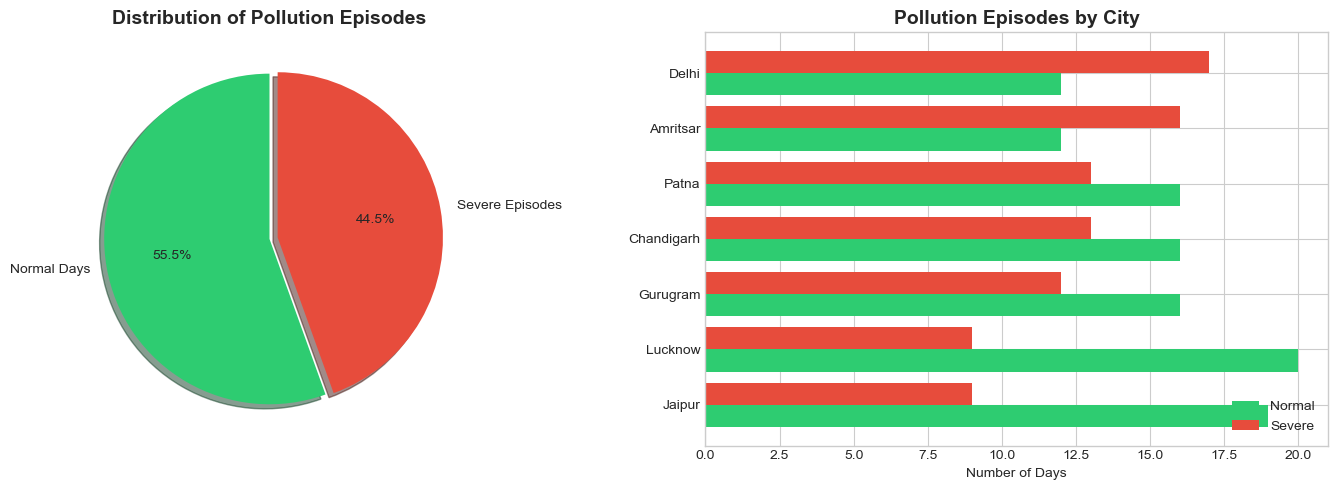

In [21]:
# Create target distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#2ecc71', '#e74c3c']
labels = ['Normal Days', 'Severe Episodes']
sizes = dataset_final['severe_episode'].value_counts().sort_index().values
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0, 0.05), shadow=True)
axes[0].set_title('Distribution of Pollution Episodes', fontsize=14, fontweight='bold')
city_data = dataset_final.groupby('city')['severe_episode'].agg(['sum', 'count'])
city_data['normal'] = city_data['count'] - city_data['sum']
city_data = city_data.sort_values('sum', ascending=True)
y_pos = np.arange(len(city_data))
axes[1].barh(y_pos - 0.2, city_data['normal'], 0.4, label='Normal', color='#2ecc71')
axes[1].barh(y_pos + 0.2, city_data['sum'], 0.4, label='Severe', color='#e74c3c')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(city_data.index)
axes[1].set_xlabel('Number of Days')
axes[1].set_title('Pollution Episodes by City', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
plt.tight_layout()
plt.savefig('data/final/viz1_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

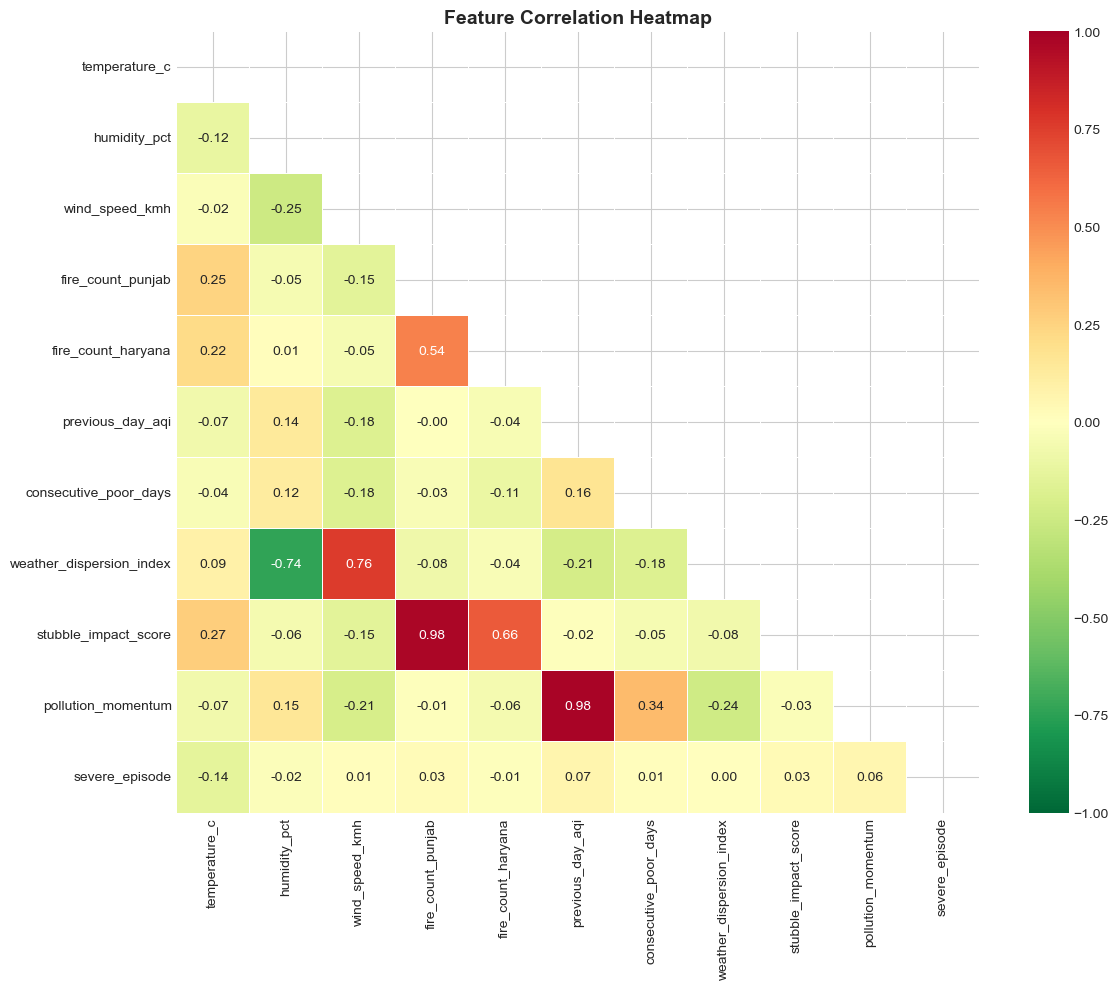

In [22]:
# Create correlation heatmap
numeric_cols = ['temperature_c', 'humidity_pct', 'wind_speed_kmh', 'fire_count_punjab', 'fire_count_haryana', 'previous_day_aqi', 'consecutive_poor_days', 'weather_dispersion_index', 'stubble_impact_score', 'pollution_momentum', 'severe_episode']
corr_matrix = dataset_final[numeric_cols].corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlGn_r', center=0, fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('data/final/viz2_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

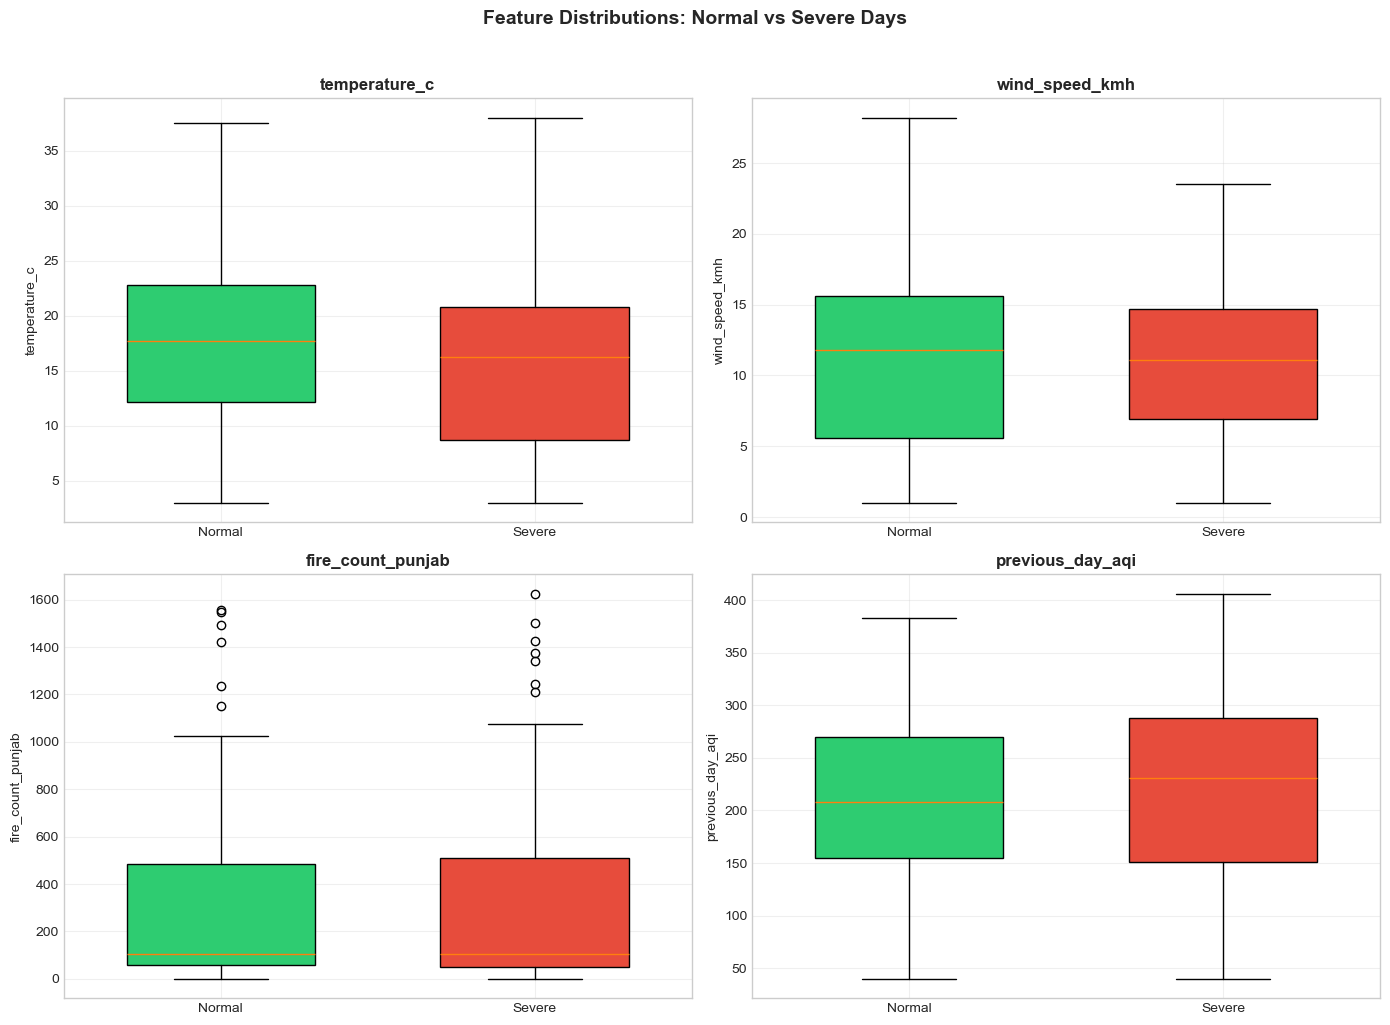

In [23]:
# Create box plots for feature distributions
features_to_plot = ['temperature_c', 'wind_speed_kmh', 'fire_count_punjab', 'previous_day_aqi']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for idx, feature in enumerate(features_to_plot):
    data_0 = dataset_final[dataset_final['severe_episode'] == 0][feature]
    data_1 = dataset_final[dataset_final['severe_episode'] == 1][feature]
    bp = axes[idx].boxplot([data_0, data_1], labels=['Normal', 'Severe'], patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, alpha=0.3)
plt.suptitle('Feature Distributions: Normal vs Severe Days', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('data/final/viz3_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

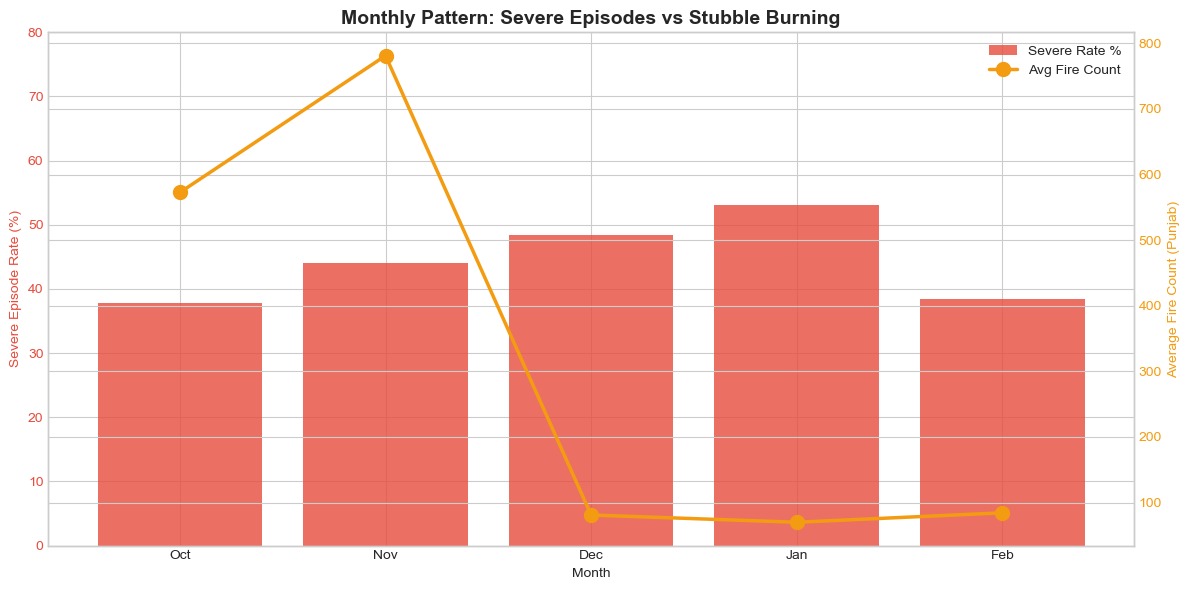

In [24]:
# Create monthly pattern visualization
monthly_data = dataset_final.groupby('month').agg({'severe_episode': ['sum', 'count', 'mean'], 'fire_count_punjab': 'mean'}).reset_index()
monthly_data.columns = ['month', 'severe_count', 'total', 'severe_rate', 'avg_fires']
month_order = {10: 1, 11: 2, 12: 3, 1: 4, 2: 5}
month_names = {10: 'Oct', 11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb'}
monthly_data['order'] = monthly_data['month'].map(month_order)
monthly_data = monthly_data.sort_values('order')
monthly_data['month_name'] = monthly_data['month'].map(month_names)
fig, ax1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(monthly_data))
ax1.bar(x, monthly_data['severe_rate']*100, color='#e74c3c', alpha=0.8, label='Severe Rate %')
ax1.set_xlabel('Month')
ax1.set_ylabel('Severe Episode Rate (%)', color='#e74c3c')
ax1.tick_params(axis='y', labelcolor='#e74c3c')
ax1.set_xticks(x)
ax1.set_xticklabels(monthly_data['month_name'])
ax1.set_ylim(0, 80)
ax2 = ax1.twinx()
ax2.plot(x, monthly_data['avg_fires'], 'o-', color='#f39c12', linewidth=2.5, markersize=10, label='Avg Fire Count')
ax2.set_ylabel('Average Fire Count (Punjab)', color='#f39c12')
ax2.tick_params(axis='y', labelcolor='#f39c12')
plt.title('Monthly Pattern: Severe Episodes vs Stubble Burning', fontsize=14, fontweight='bold')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.tight_layout()
plt.savefig('data/final/viz4_monthly_pattern.png', dpi=150, bbox_inches='tight')
plt.show()

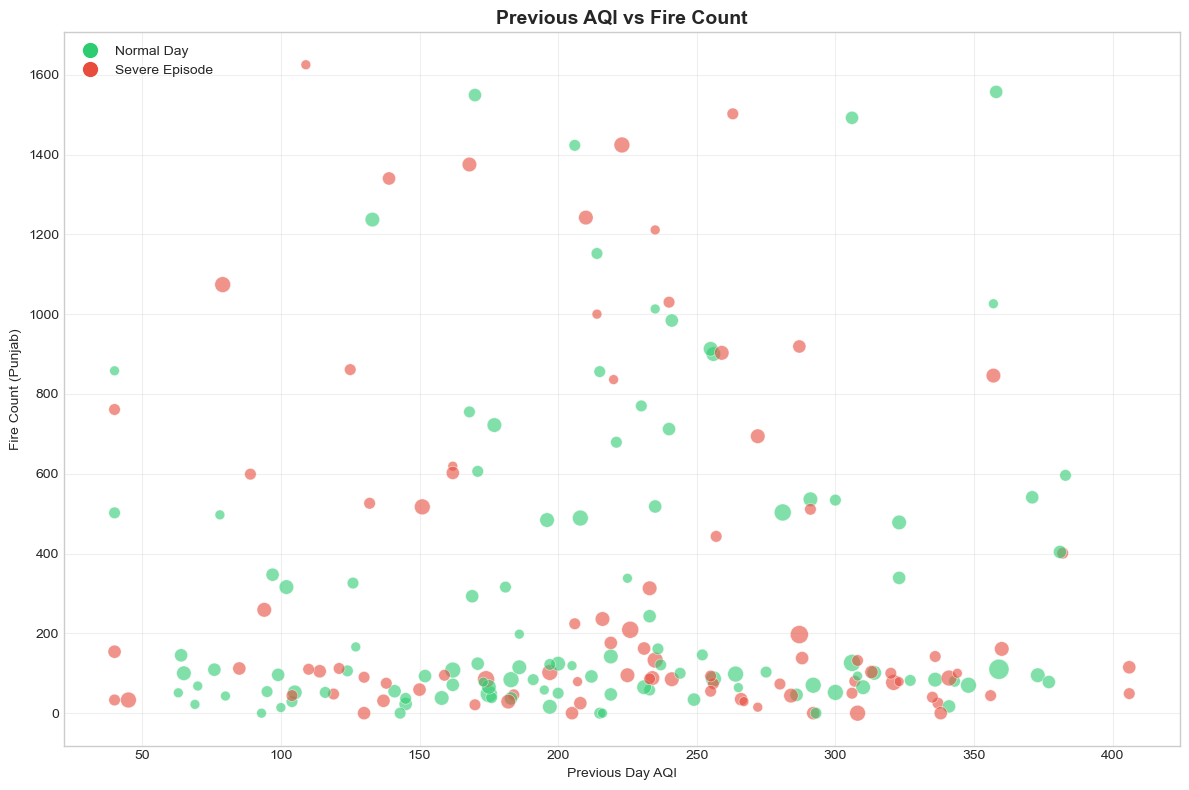

In [25]:
# Create scatter plot
plt.figure(figsize=(12, 8))
colors = ['#2ecc71' if x == 0 else '#e74c3c' for x in dataset_final['severe_episode']]
sizes = dataset_final['consecutive_poor_days'] * 20 + 50
plt.scatter(dataset_final['previous_day_aqi'], dataset_final['fire_count_punjab'], c=colors, s=sizes, alpha=0.6, edgecolors='white', linewidth=0.5)
plt.xlabel('Previous Day AQI')
plt.ylabel('Fire Count (Punjab)')
plt.title('Previous AQI vs Fire Count', fontsize=14, fontweight='bold')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=12, label='Normal Day'), Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=12, label='Severe Episode')]
plt.legend(handles=legend_elements, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/final/viz5_scatter_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Save base dataset
base_columns = ['record_id', 'city', 'date', 'month', 'temperature_c', 'humidity_pct', 'wind_speed_kmh', 'wind_direction_deg', 'fire_count_punjab', 'fire_count_haryana', 'days_from_diwali', 'previous_day_aqi', 'consecutive_poor_days', 'severe_episode']
base_dataset = dataset_final[base_columns].copy()
base_dataset['date'] = base_dataset['date'].dt.strftime('%Y-%m-%d')
base_dataset.to_csv('data/final/pollution_episode_dataset.csv', index=False)

In [27]:
# Save extended dataset with engineered features
extended_dataset = dataset_final.copy()
extended_dataset['date'] = extended_dataset['date'].dt.strftime('%Y-%m-%d')
extended_dataset.to_csv('data/final/pollution_dataset_with_features.csv', index=False)

In [28]:
# Display sample data
print(base_dataset.head(10))

   record_id        city        date  month  temperature_c  humidity_pct  \
0          1  Chandigarh  2021-11-09     11           20.4          98.0   
1          2       Delhi  2022-01-03      1            3.0          65.6   
2          3     Lucknow  2021-01-24      1            4.1          59.2   
3          4      Jaipur  2022-01-09      1            9.8          84.1   
4          5    Gurugram  2021-02-24      2           12.8          87.5   
5          6  Chandigarh  2021-11-05     11           15.1          48.7   
6          7       Patna  2021-02-19      2           23.3          49.6   
7          8      Jaipur  2019-11-01     11           10.3          58.6   
8          9    Amritsar  2022-01-15      1           17.1          83.1   
9         10     Lucknow  2019-10-01     10           20.8          59.0   

   wind_speed_kmh  wind_direction_deg  fire_count_punjab  fire_count_haryana  \
0             9.2               154.0               1502                 569   
1  

In [29]:
# Final verification
df_verify = pd.read_csv('data/final/pollution_dataset_with_features.csv')
numeric_cols = df_verify.select_dtypes(include=[np.number]).columns
correlations = df_verify[numeric_cols].corr()['severe_episode'].drop('severe_episode').abs().sort_values(ascending=False)
print(f"Max correlation: {correlations.max():.3f}")
print(correlations.head(5))

Max correlation: 0.137
temperature_c         0.137396
wind_direction_deg    0.132629
diwali_impact_zone    0.103195
previous_day_aqi      0.069401
pollution_momentum    0.056690
Name: severe_episode, dtype: float64
